In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

from scipy.stats import norm

# Let's first generate some synthetic data

### Generate 4 basis Gaussians

(-0.050000000000000003, 1.05, -0.19946496527279667, 4.1887656074229564)

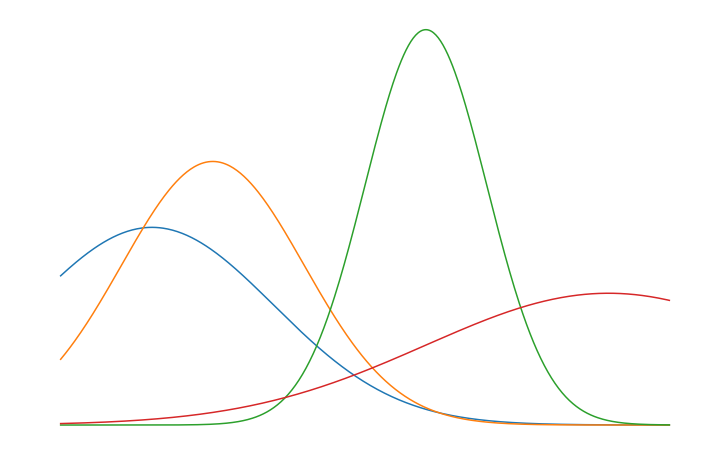

In [2]:
t = np.linspace(0, 1, 512)

mus = [.15, .25, .6, .9]
sigmas = [.2, .15, .1, .3]

G = []

for mu,sigma in zip(mus, sigmas):
    G.append( norm.pdf(t, mu, sigma) )

G = np.array(G).T

fig = plt.figure(figsize=(12, 8))

#print([m for m in dir(fig) if 'ax' in m])

for g_k in G.T:
    ax = plt.plot(t, g_k)

plt.axis('off')
    
#plt.xlabel("$ t $", size=16)
#plt.ylabel("$ g_k $", size=16)

### Generate X

In [3]:
N = 2**12

print("generating", N, "samples")

d = G.shape[1]

print(d, "basis functions chosen")

m = G.shape[0]

nu = np.random.rand(*(N, d))

X = nu @ G.T

print("X generated")

generating 4096 samples
4 basis functions chosen
X generated


### Visualize X

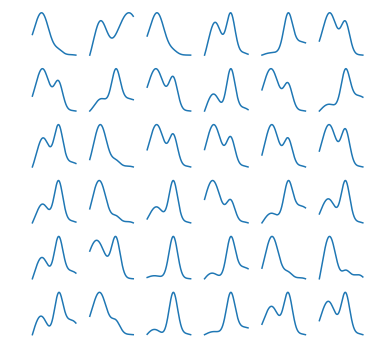

In [4]:
fig = plt.figure()

N_plot = 36
sN_plot = int(np.sqrt(N_plot))
assert N_plot%sN_plot == 0, "Enter a square value to plot"

fdim = max(sN_plot, 5)
plt.figure(figsize=(fdim, fdim))

for i in range(N_plot):
    
    sp = plt.subplot(fdim, fdim, i+1)
    sp.set_axis_off()
    #print([s for s in dir(sp) if ("axis" in s)]); break
    
    plt.plot(X[i])

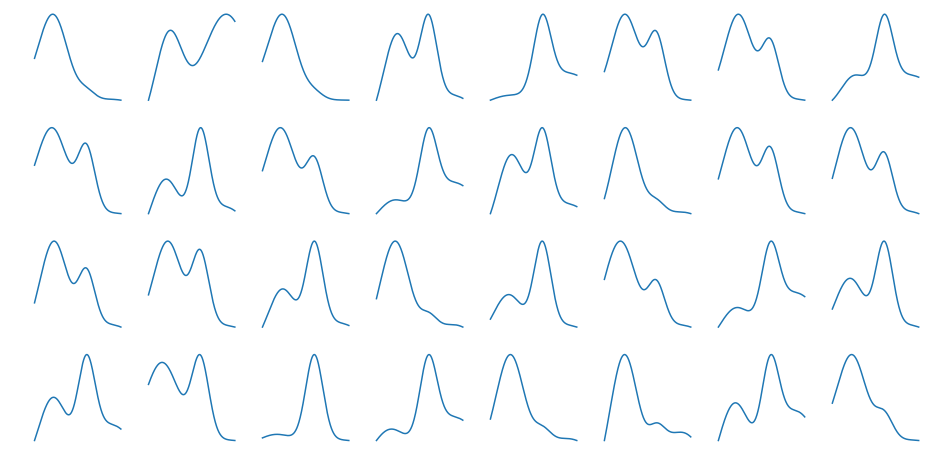

In [5]:
N_rows = 4
N_cols = 8

plt.figure(figsize=(N_cols*2, N_rows*2))

for i in range(N_rows*N_cols):
    
    sp = plt.subplot(N_rows, N_cols, i+1)
    
    sp.set_axis_off()
    
    plt.plot(X[i])

# Create the algorithm

In [6]:
class NMF():
    
    def __init__(self, d=4):
        self.hidden_dim_ = d
        
    def fit(self, X, n_steps=64, sample_index=0, log_features=True, log_recon=True):
               
        ### initialize
        if sample_index is 0:
            X = X.T
        W = np.random.rand(*(X.shape[0], self.hidden_dim_))
        V = np.random.rand(*(self.hidden_dim_, X.shape[1]))
        
        ### Run algo
        # vars
        loss = []
        W_trace = [np.copy(W)]
        recon_trace = [W @ V[:,:100]]
        # loop        
        for _ in range(n_steps):
            # Update W, V
            W = W * (X @ V.T) / (W @ V @ V.T)
            V = V * (W.T @ X) / (W.T @ W @ V)
            # Store W, V
            #W, V = W_, V_
            # Account for loss 
            # Loss is NMSE
            loss.append( ((X - W @ V)**2).mean(axis=(0,1)) ) 
            # log intermediate results if necessary
            if log_features:
                W_trace.append( np.copy(W) )
            if log_recon:
                recon_trace.append( W @ V[:,:100] )
        
        # store variable pointers
        self.data_ = X
        self.features_ = W
        self.coefficients_ = V
        self.loss_ = loss
        self.features_trace_ = W_trace
        self.recon_trace_ = recon_trace
    
    @property
    def reconstruction(self):
        try:
            return self.reconstruction_
        except:
            self.reconstruction_ = self.features_ @ self.coefficients_
            return self.reconstruction_
       

In [7]:
model = NMF(d=4)

model.fit(X, n_steps=2**8)

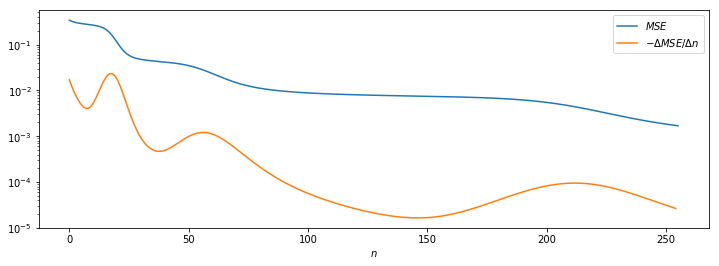

In [8]:
N_rows = 2

plt.figure(figsize=(12,4))

# plt.subplot(1,N_rows,1)
# plt.plot(model.loss_)

# plt.subplot(1,N_rows,2)
plt.plot(model.loss_, label="$MSE$")
plt.plot(-np.diff(model.loss_), label="$ - \Delta MSE / {\Delta n}$")
plt.yscale("log")
plt.xlabel("$n$")

plt.legend()

(-0.050000000000000003, 1.05, -0.19946496527279667, 4.1887656074229564)

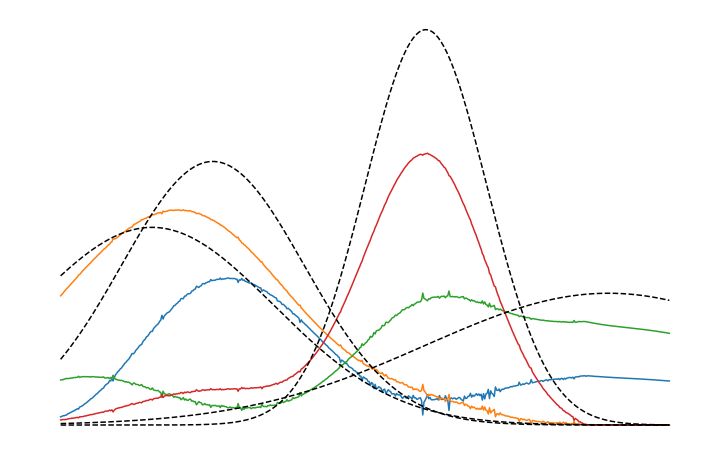

In [9]:
plt.figure(figsize=(12, 8))

plt.plot(t, model.features_)
plt.plot(t, G, 'k--')

plt.axis('off')

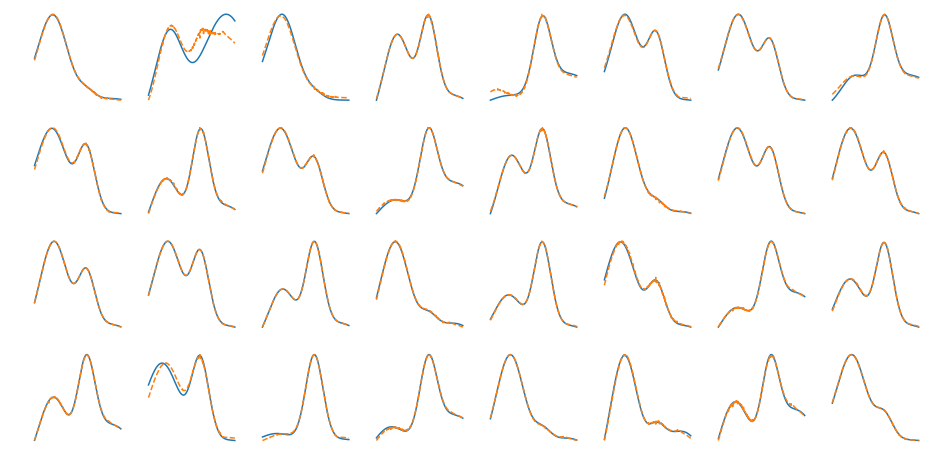

In [10]:
N_rows = 4
N_cols = 8

plt.figure(figsize=(N_cols*2, N_rows*2))

for i in range(N_rows*N_cols):
    
    sp = plt.subplot(N_rows, N_cols, i+1)
    
    sp.set_axis_off()
    
    plt.plot(X[i])
    plt.plot(model.reconstruction.T[i], '--')

# Create function animations

In [11]:
from matplotlib.animation import FuncAnimation 
from matplotlib.pyplot import plot, show, subplots, title  # annotate
from IPython.display import HTML, Image

### Loss and Basis Animation

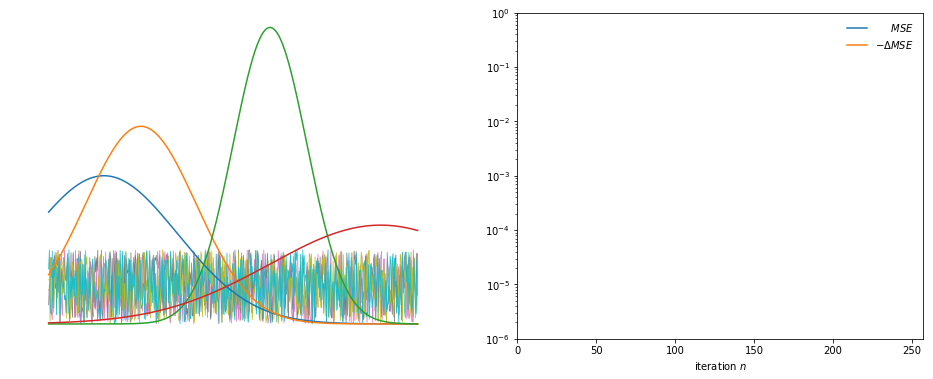

In [12]:
fig = plt.figure(figsize=(16,6))

### first, plot basis functions

W_trace = np.array(model.features_trace_)

plt.subplot(1,2,1)

lines = []
for w,c in zip(W_trace[0].T, ["#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]):
    lines.append( plt.plot(w, c, lw=.75)[0] )

for g,c in zip(G.T, ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]):
    plt.plot(g, c)

plt.axis('off')

### next, plot

plt.subplot(1,2,2)

line_loss, = plt.semilogy([], [], label="     $MSE$")
line_grad, = plt.semilogy([], [], label="$ - \Delta MSE$")
point_loss = plt.scatter
plt.xlim([0, len(W_trace)])
plt.ylim([10**-6, 1])
plt.xlabel("iteration $n$", )

plt.legend(frameon=False)

### create the animation
n_vec = np.arange(len(model.loss_))
t = np.arange(W_trace.shape[1])
model.grad_ = -np.diff(model.loss_)
loss, grad = model.loss_, model.grad_
def update_fig(i):
    # update lines
    for line,w in zip(lines, W_trace[i].T):
        line.set_data(t, w)
    # update loss lines
    line_loss.set_data(n_vec[:i+1], loss[:i+1])
    line_grad.set_data(n_vec[1:i+1], grad[:i])
    # update iteration count
    
n_frames = len(W_trace)
#n_frames = 16
anim = FuncAnimation(fig, update_fig, frames=n_frames, interval=60) #W_trace.shape[0])   

#HTML(anim.to_html5_video())



In [13]:
# HTML(anim.to_html5_video())

In [14]:
# anim.save('../assets/media/Non-Negative-Matrix-Factorization/Loss_anim3.gif', writer='imagemagick', fps=60)

In [15]:
# Image('../assets/media/Non-Negative-Matrix-Factorization/Loss_anim0.gif')

### Reconstruction Animation

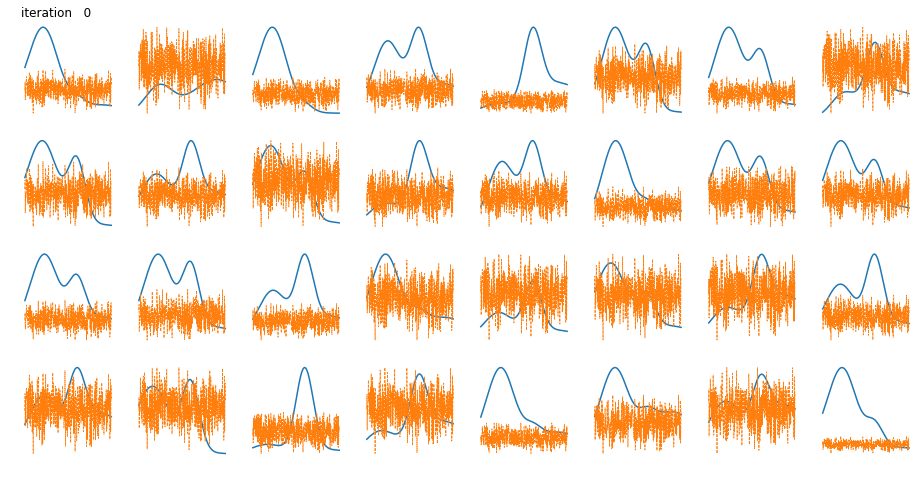

In [17]:
N_rows = 4
N_cols = 8

fig2 = plt.figure(figsize=(N_cols*2, N_rows*2))

recon_trace = model.recon_trace_

lines = []
text = None

for i in range(N_rows*N_cols):  
    
    sp = plt.subplot(N_rows, N_cols, i+1)
    
    sp.set_axis_off()
    
    if i is 0:
        text = plt.title(" iteration {:3d}".format(0), loc='left')  
    
    plt.plot(t, X[i])

    lines.append( plt.plot(recon_trace[0].T[i], '--', lw=.75)[0] )
    
            
def update_fig(i):
    # update recon lines
    for line,recon in zip(lines, recon_trace[i].T):
        line.set_data(t, recon)
    # set iteration tick
    text.set_text("iteration {:3d}".format(i))
    
    
n_frames = 256
    
anim2 = FuncAnimation(fig2, update_fig, frames=n_frames, interval=60) 



In [18]:
# HTML(anim2.to_html5_video())

In [19]:
# anim2.save('../assets/media/Non-Negative-Matrix-Factorization/Gaussians_recon2.gif', writer='imagemagick', fps=60)1